In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image

# own imports
import sys
sys.path.append("../")

from models import DRAW
from layers import BaseAttention

cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
print(device)

cuda:0


# Load Binarized MNIST Data

In [24]:
# Define batch size
BATCH_SIZE = 64

In [25]:
# define lambda func
def tmp_lambda(x):
    return torch.bernoulli(x)

# Load the data
mnist_data = MNIST(
    './', 
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(tmp_lambda)
    ])
)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
data_loader = DataLoader(
    mnist_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    **kwargs
)

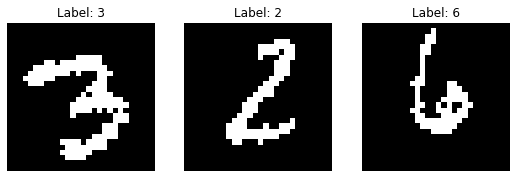

In [26]:
# plot some exampels
data_iter = iter(data_loader)
images, labels = data_iter.next()
N=3
f, ax = plt.subplots(1, N, figsize=(3*N, 6))
for i in range(N):
    if N == 1:
        ax.imshow(images[i, 0], cmap='gray')
        ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')
    else:
        ax[i].imshow(images[i, 0], cmap='gray')
        ax[i].set_title(f'Label: {labels[i]}')
        ax[i].axis('off')
plt.show()

# Train DRAW Model

In [28]:
# create model and optimizer
model = DRAW(x_dim=784, h_dim=256, z_dim=16, T=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.5)

# loss
loss = nn.BCELoss(reduction='none').to(device)

In [29]:
EPOCHS = 100

In [30]:
# training loop
for epoch in range(EPOCHS):
    model.train()
    for x, _ in tqdm(data_loader):
        batch_size = x.size(0)

        x = x.view(batch_size, -1).to(device)

        x_hat, kld = model(x)
        x_hat = torch.sigmoid(x_hat)

        reconstruction = loss(x_hat, x).sum(1)
        kl = kld.sum(1)
        elbo = torch.mean(reconstruction + kl)

        elbo.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    scheduler.step()

    # Evaluate on test set
    # 1 forward pass in test set for loss
    model.eval()
    with torch.no_grad():

        # if epoch % 1 == 0:
          
        
        # print train loss and save sample + recon
        if epoch % 10 == 0:
            print("\nLoss at step {}: {}".format(epoch, elbo.item()))
            x_sample = model.sample()
            save_image(x_hat, "reconstruction-{}.jpg".format(epoch))
            save_image(x_sample, "sample-{}.jpg".format(epoch))

  0%|          | 0/938 [00:00<?, ?it/s]


Loss at step 0: 115.5919189453125


  0%|          | 0/938 [00:00<?, ?it/s]


Loss at step 10: 95.78974914550781


  0%|          | 0/938 [00:00<?, ?it/s]


Loss at step 20: 87.64845275878906


  0%|          | 0/938 [00:00<?, ?it/s]


Loss at step 30: 95.54304504394531


  0%|          | 0/938 [00:00<?, ?it/s]


Loss at step 40: 79.78327941894531


  0%|          | 0/938 [00:00<?, ?it/s]


Loss at step 50: 92.98652648925781


  0%|          | 0/938 [00:00<?, ?it/s]


Loss at step 60: 85.64823913574219


  0%|          | 0/938 [00:00<?, ?it/s]


Loss at step 70: 87.84520721435547


  0%|          | 0/938 [00:00<?, ?it/s]


Loss at step 80: 87.15818786621094


  0%|          | 0/938 [00:00<?, ?it/s]


Loss at step 90: 82.77556610107422


100%|██████████| 938/938 [00:24<00:00, 37.82it/s]


# Plot Samples

In [31]:
from matplotlib import image

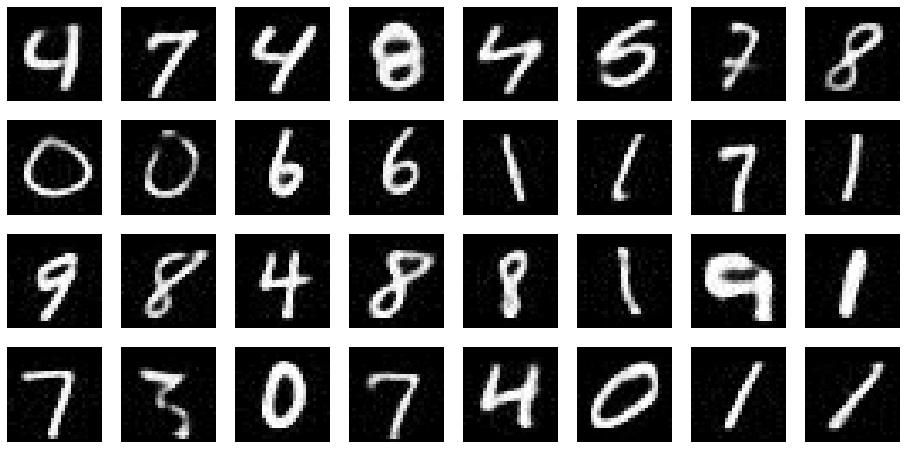

In [33]:
img = image.imread('reconstruction-90.jpg')[:, :, 0]

f, ax = plt.subplots(4, 8, figsize=(16,8))
for i in range(8):
    idx = i*4

    for j in range(4):
        ax[j, i].imshow(np.reshape(img[idx+j, :], (28,28)), cmap='gray')
        ax[j, i].axis('off')
plt.show()

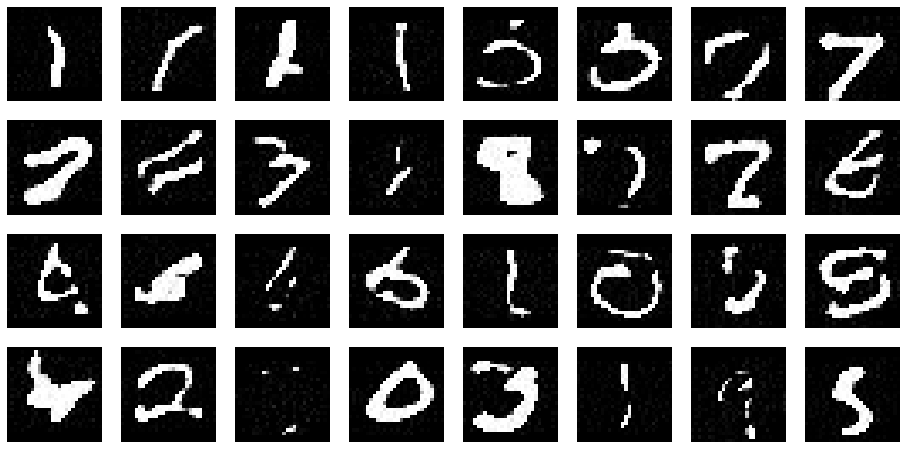

In [38]:
img = image.imread('sample-90.jpg')[:, :, 0]

f, ax = plt.subplots(4, 8, figsize=(16,8))
for i in range(8):
    idx = i*4

    for j in range(4):
        ax[j, i].imshow(np.reshape(img[idx+j, :], (28,28)), cmap='gray')
        ax[j, i].axis('off')
plt.show()